# Bill Cobb's Vehicle Dynamics Professional's July 2024 Challenge

Given the output of a constant steer, variable speed understeer gradient test, compute the understeer gradient at 0.15 lateral G. The vehicle is a generic car with non-linear steering and non-linear tires.

The original challenge from Bill Cobb:

> Here is a .csv file produced from a simulation I regularly use.  It's a generic 'car' with a nonlinear steering system and a nonlinear tire on each axle.
> What's the understeer value at 0.15g lateral acceleration ?
> Use any processing language or other tool to produce a plot of the understeer function with the designated metric clearly labeled. 

In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp

In [3]:
plt.style.use('seaborn-v0_8')

## Part 1: Data Wrangling

### Load in the data

Read in the data and sanitize it for consumption. The data has the following form:
    
| Row number | Description | Sample |
| ---------- | ----------- | ------ |
| Line 1     | Comment header describing the contents of the CSV and relevant vehicle parameters | `"BZ3 Nonlinear Vehicle Dynamics Simulation Constant Steer Ramp Speed Test  WB=2745 mm"` |
| Line 2     | Column header names and units | `"TIME, sec";"SPEED, kph";"YAWVEL, deg/sec";                 ;` |
| Line 3+    | Time series data | `0.000    ;20.000   ;0.000    ` |

In [4]:
FILE_PATH = "data/marc1.txt"

In [5]:
df = pl.read_csv(FILE_PATH, skip_rows=1, columns=[0, 1, 2], separator=";").with_columns(
    pl.col("*").str.extract(r"(\d+[.\d]*)").str.to_decimal()
)

Drop the first 0.2 seconds since it contains transients as suggested by Bill Cobb.

In [6]:
TIME_COL = "TIME, sec"

In [7]:
df = df.filter(pl.col(TIME_COL) > 0.2)
df

"TIME, sec","SPEED, kph","YAWVEL, deg/sec"
"decimal[*,3]","decimal[*,3]","decimal[*,3]"
0.210,20.756,2.982
0.220,20.792,2.990
0.230,20.828,2.998
0.240,20.864,3.006
0.250,20.900,3.013
…,…,…
32.960,138.659,10.734
32.970,138.695,10.734
32.980,138.731,10.734


### Visualize provided data

Plot the timeseries to see what we are working with.

In [8]:
SPEED_COL = "SPEED, kph"
YAWVEL_COL = "YAWVEL, deg/sec"

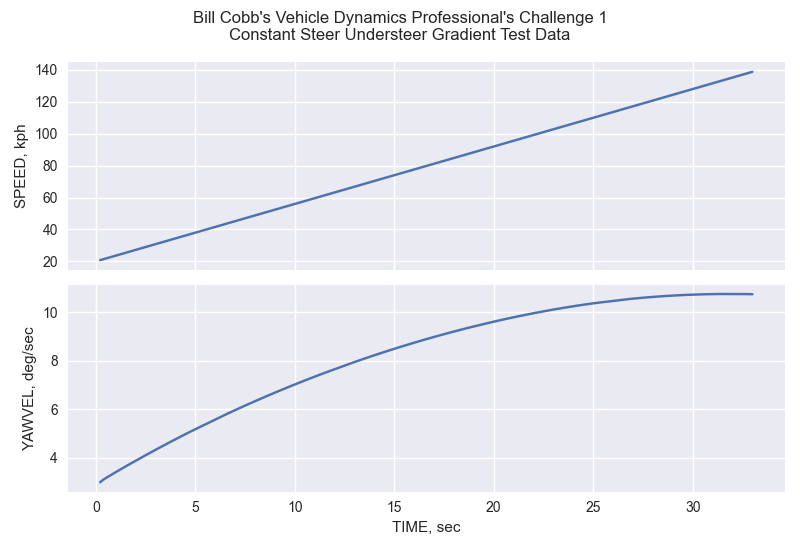

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True)

# Plot
axes[0].plot(df[TIME_COL], df[SPEED_COL])
axes[1].plot(df[TIME_COL], df[YAWVEL_COL])

# Labels
axes[0].set_ylabel(SPEED_COL)
axes[1].set_ylabel(YAWVEL_COL)
axes[1].set_xlabel(TIME_COL)

# Title
fig.suptitle("Bill Cobb's Vehicle Dynamics Professional's Challenge 1\nConstant Steer Understeer Gradient Test Data")

plt.tight_layout()
plt.show()

## Part 2: Understeer Gradient

The understeer gradient is a gain on lateral acceleration that modifies the required road wheel angle to meet a specified corner radius. Recall:

$$ \delta = \frac{L}{R} + Ka_y $$

Where
* $\delta$ is the road wheel angle [rad]
* $L$ is the wheelbase [m]
* $R$ is the radius of the turn [m]
* $a_y$ is the lateral acceleration [m/s^2]
* $K$ is the understeer gradient [rad/m/s^2]

A constant steer understeer gradient test can be thought of as constant steer, variable radius and lateral acceleration.

$$
0 = L dR + K da_y \\
K = -L \frac{dR}{da_y}
$$

Given the following relationships.

$$
a_y = u\omega \\
u = \omega R
$$

The understeer gradient equation for a constant steer understeer gradient test becomes the following.

$$
K = -L \frac{d(\frac{w}{u})}{d(u\omega)}
$$

Source: Bundorf, R. Thomas. "The influence of vehicle design parameters on characteristic speed and understeer." SAE Transactions (1968): 548-560.

### Compute math channels

All calculations are performed in SI units. Compute corner radius and lateral acceleration.

In [10]:
# COLUMN NAMES
SPEED_SI_COL = "SPEED, m/s"
YAWVEL_SI_COL = "YAWVEL, rad/sec"
RADIUS_COL = "RADIUS, m"
LATACC_COL = "LATACC, m/s^2"
DRADIUS_COL = "RADIUS_DIFF, m"
DLATACC_COL = "LATACC DIFF, m/s^2"

# CONVERSION FACTORS
KPH_TO_MPS = 1000 / 3600.0
DEG_TO_RAD = np.pi / 180.0

In [11]:
# Compute SI channels
df = df.with_columns(
    (pl.col(SPEED_COL).cast(pl.Float32) * KPH_TO_MPS).alias(SPEED_SI_COL),
    (pl.col(YAWVEL_COL).cast(pl.Float32) * DEG_TO_RAD).alias(YAWVEL_SI_COL),
)

# Compute math channels
df = df.with_columns(
    (pl.col(YAWVEL_SI_COL) / pl.col(SPEED_SI_COL)).alias(RADIUS_COL),
    (pl.col(YAWVEL_SI_COL) * pl.col(SPEED_SI_COL)).alias(LATACC_COL),
)

df

"TIME, sec","SPEED, kph","YAWVEL, deg/sec","SPEED, m/s","YAWVEL, rad/sec","RADIUS, m","LATACC, m/s^2"
"decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32
0.210,20.756,2.982,5.765556,0.052046,0.009027,0.300073
0.220,20.792,2.990,5.775556,0.052185,0.009036,0.301399
0.230,20.828,2.998,5.785555,0.052325,0.009044,0.302729
0.240,20.864,3.006,5.795556,0.052465,0.009053,0.304062
0.250,20.900,3.013,5.805556,0.052587,0.009058,0.305295
…,…,…,…,…,…,…
32.960,138.659,10.734,38.516388,0.187344,0.004864,7.2158
32.970,138.695,10.734,38.526394,0.187344,0.004863,7.217675
32.980,138.731,10.734,38.536392,0.187344,0.004861,7.219548


### Compute the understeer gradient

Recall that the understeer gradient for a constant steer understeer gradient test is as follows.

$$
K = -L \frac{d(\frac{w}{u})}{d(u\omega)}
$$

In [12]:
# Constants
WHEELBASE = 2.745

# Column names
USG_COL = "USG, rad/m/s^2"

Fit a spline with smoothing factor $s$ to compute smooth gradients.

In [13]:
def gradient(y, s=0.2):
    x = range(len(y))
    f = sp.interpolate.splrep(x, y, s=s)
    return sp.interpolate.splev(x, f, der=1)


df = df.with_columns(
    pl.Series(
        name=USG_COL,
        values=-WHEELBASE
        * gradient((df[YAWVEL_COL] / df[SPEED_SI_COL]).to_numpy())
        / gradient((df[YAWVEL_COL] * df[SPEED_SI_COL]).to_numpy()),
    )
)
df

"TIME, sec","SPEED, kph","YAWVEL, deg/sec","SPEED, m/s","YAWVEL, rad/sec","RADIUS, m","LATACC, m/s^2","USG, rad/m/s^2"
"decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f64
0.210,20.756,2.982,5.765556,0.052046,0.009027,0.300073,0.003354
0.220,20.792,2.990,5.775556,0.052185,0.009036,0.301399,0.003354
0.230,20.828,2.998,5.785555,0.052325,0.009044,0.302729,0.003354
0.240,20.864,3.006,5.795556,0.052465,0.009053,0.304062,0.003354
0.250,20.900,3.013,5.805556,0.052587,0.009058,0.305295,0.003354
…,…,…,…,…,…,…,…
32.960,138.659,10.734,38.516388,0.187344,0.004864,7.2158,0.002012
32.970,138.695,10.734,38.526394,0.187344,0.004863,7.217675,0.002013
32.980,138.731,10.734,38.536392,0.187344,0.004861,7.219548,0.002014


### Extract metrics

We want to know the value of the understeer gradient at 0.15 G. Interpolate and compute the required metrics.

In [14]:
STD_G = 9.81
RAD_TO_DEG = 1 / DEG_TO_RAD
TARGET_AY = 0.15

In [15]:
def interpolate(x, y, xeval):
    f = sp.interpolate.splrep(x, y)
    return sp.interpolate.splev(xeval, f)

target_ay = TARGET_AY * STD_G
target_usg = interpolate(df[LATACC_COL], df[USG_COL], target_ay)
print(f"Understeer Gradient @ 0.15G: {(target_usg * STD_G * RAD_TO_DEG):.3} deg/G")

Understeer Gradient @ 0.15G: 1.05 deg/G


### Visualize

Plot the results of the analysis.

In [16]:
FIG_SCALE = 0.66
ANNOTATION_OFFSET = 0.02

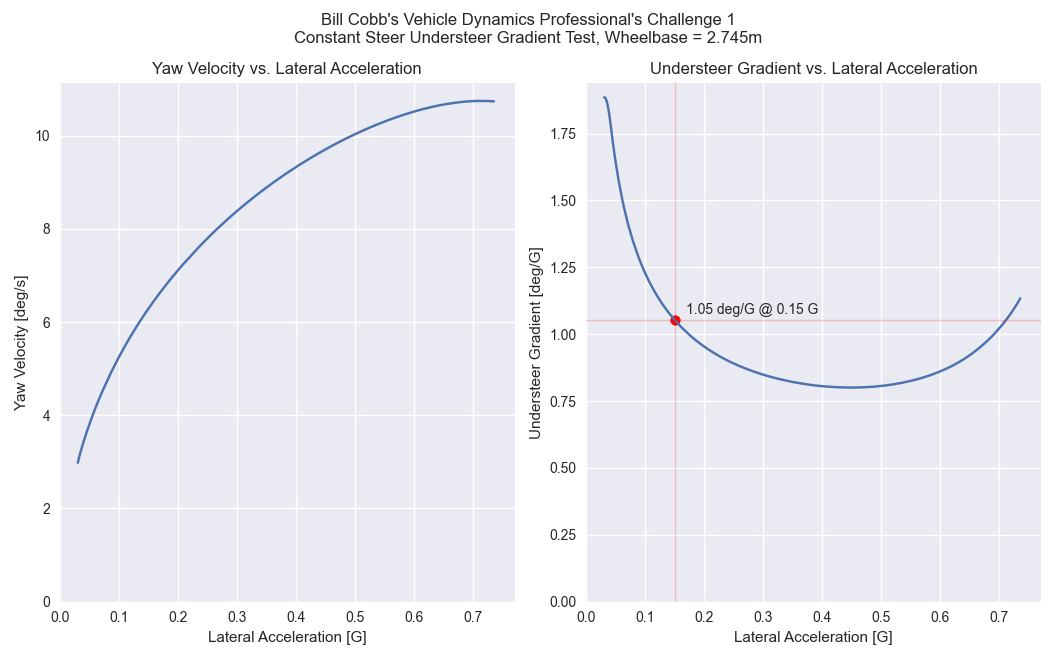

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(FIG_SCALE * 16, FIG_SCALE * 10))

# Left axis
axes[0].plot(df[LATACC_COL] / STD_G, df[YAWVEL_SI_COL] * RAD_TO_DEG)
axes[0].set_title("Yaw Velocity vs. Lateral Acceleration")
axes[0].set_xlabel("Lateral Acceleration [G]")
axes[0].set_ylabel("Yaw Velocity [deg/s]")
axes[0].set_ylim(bottom=0)
axes[0].set_xlim(left=0)

# Right axis
axes[1].plot(df[LATACC_COL] / STD_G, df[USG_COL] * STD_G * RAD_TO_DEG)
axes[1].scatter(TARGET_AY, target_usg * STD_G * RAD_TO_DEG, c="red")
axes[1].axvline(TARGET_AY, linewidth=1, c="red", alpha=0.2)
axes[1].axhline(target_usg * STD_G * RAD_TO_DEG, linewidth=1, c="red", alpha=0.2)
axes[1].annotate(
    f"{target_usg * STD_G * RAD_TO_DEG:.3} deg/G @ 0.15 G",
    (
        TARGET_AY + ANNOTATION_OFFSET,
        target_usg * STD_G * RAD_TO_DEG + ANNOTATION_OFFSET,
    ),
)
axes[1].set_title("Understeer Gradient vs. Lateral Acceleration")
axes[1].set_xlabel("Lateral Acceleration [G]")
axes[1].set_ylabel("Understeer Gradient [deg/G]")
axes[1].set_ylim(bottom=0)
axes[1].set_xlim(left=0)

# Figure
fig.suptitle(
    "Bill Cobb's Vehicle Dynamics Professional's Challenge 1\nConstant Steer Understeer Gradient Test, Wheelbase = 2.745m"
)

plt.tight_layout()
plt.show()